# This notebook plots mean precipitation maps with regional mean between 2 sources of data for a single tracker
## The mean precipitation map data is produced by:
* /src/calc_tbpf_mcs_rainmap_mcsmip.py

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import colorcet as cc
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

run_name1 = 'OBS'
# run_name2 = 'SCREAM'
run_name2 = 'OBSv7'
# run_name1 = 'SCREAM'
# run_name2 = 'SCREAMv1'

tracker = 'PyFLEXTRKR'

indir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/{tracker}/'
infile1 = f'{indir}mcs_rainmap_{PHASE}_{run_name1}.nc'
infile2 = f'{indir}mcs_rainmap_{PHASE}_{run_name2}.nc'

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)
print(f'{infile1} exists: {os.path.isfile(infile1)}')
print(f'{infile2} exists: {os.path.isfile(infile2)}')

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/PyFLEXTRKR/
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_rainmap_Summer_OBS.nc exists: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_rainmap_Summer_OBSv7.nc exists: True


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [3]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)>
array([[-0.19099763, -0.2824136 ,  0.17526372, ...,  1.1824327 ,
         0.35849398,  0.26687884],
       [-0.19099763,  0.54152507,  0.35849398, ...,  2.2812166 ,
         1.3656629 ,  0.9994015 ],
       [-1.656043  , -0.9235203 ,  0.08384776, ...,  7.134229  ,
         0.9077864 , -0.55725896],
       ...,
       [ 0.35849398,  0.17526372,  0.17526372, ..., -0.46564385,
        -0.3740287 ,  0.17526372],
       [-0.3740287 , -0.0993825 ,  0.08384776, ...,  0.35849398,
         0.17526372,  0.17526372],
       [-0.00776737,  0.26687884, -0.00776737, ...,  0.08384776,
         0.17526372,  0.54152507]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 1979-01-01

In [5]:
# Read input files in Xarray DataSet
infiles = [infile1, infile2]
ds = xr.open_mfdataset(infiles, concat_dim='source', combine='nested')
ds['source'] = [run_name1, run_name2]

if PHASE == 'Winter':
    ds = ds.roll(lon=1800, roll_coords=True)
    # Convert longitude coordinates from -180~180 to 0~360
    lon360 = ds['lon'].data % 360
    ds = ds.assign_coords(lon=lon360)

lon = ds.lon
lat = ds.lat
ds.load()

<xarray.Dataset>
Dimensions:                  (source: 2, time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                     (time) datetime64[ns] 2016-08-10
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * source                   (source) <U5 'OBS' 'OBSv7'
Data variables:
    precipitation            (source, time, lat, lon) float32 187.8 ... 64.68
    mcs_precipitation        (source, time, lat, lon) float32 4.46 4.42 ... 0.0
    mcs_precipitation_count  (source, time, lat, lon) float32 1.0 1.0 ... 0.0
    mcs_cloud_count          (source, time, lat, lon) float32 1.0 1.0 ... 0.0
    ntimes                   (source, time) float32 744.0 745.0
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Summer
    tracker:     PyFLEXTRKR
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2016-08-10T00
    end_date:    2016-09-10T00
    created_on:  Mon Nov  6 13:46:23 2023

In [6]:
# Total number of hours
nhours = ds.ntimes.sum(dim='time')
print(f'Number of total hours: {nhours.data}')

# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp = 24. * ds.precipitation.sum(dim='time') / nhours
mcspcp = 24. * ds.mcs_precipitation.sum(dim='time') / nhours
nonmcspcp = totpcp - mcspcp
# MCS precipitation fraction
mcspcpfrac = 100 * mcspcp / totpcp

# Number of hours with MCS precipitation / cloud
mcspcphours = ds.mcs_precipitation_count.sum(dim='time')
mcscloudhours = ds.mcs_cloud_count.sum(dim='time')
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity = ds.mcs_precipitation.sum(dim='time') / mcspcphours

# MCS precipitation / cloud frequency
mcspcpfreq = 100 * (mcspcphours / nhours)
mcscloudfreq = 100 * (mcscloudhours / nhours)

Number of total hours: [744. 745.]


In [7]:
mcscloudfreq.shape

(2, 1200, 3600)

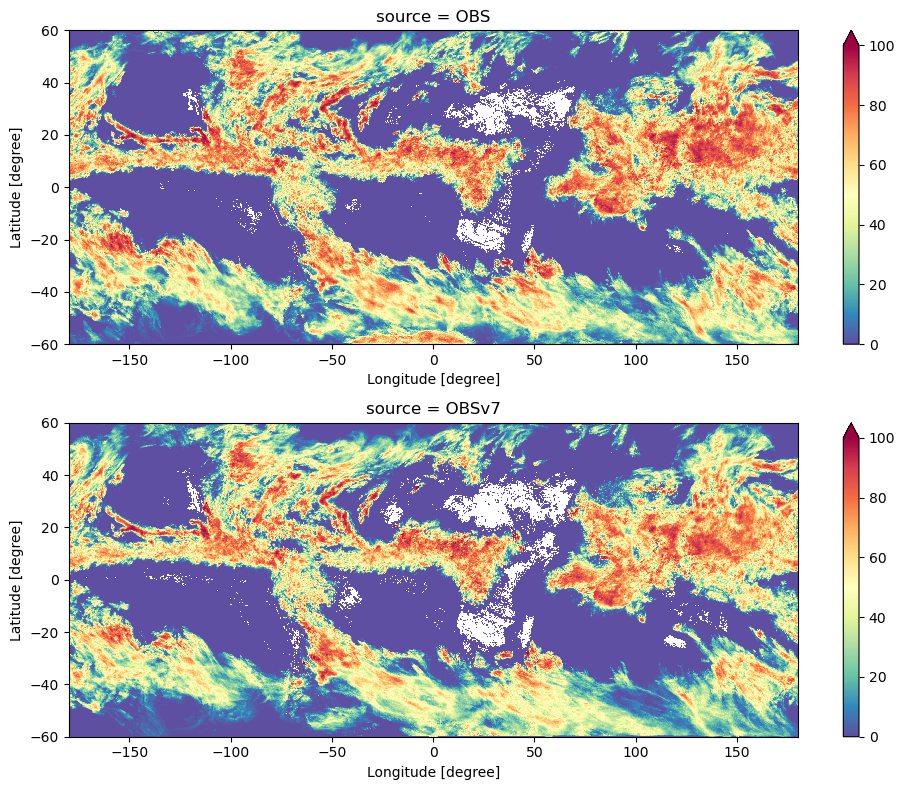

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
mcspcpfrac.sel(source=run_name1).plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[0])
mcspcpfrac.sel(source=run_name2).plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[1])
fig.tight_layout()

In [9]:
totpcp_diff = totpcp.sel(source=run_name2) - totpcp.sel(source=run_name1)
mcspcp_diff = mcspcp.sel(source=run_name2) - mcspcp.sel(source=run_name1)
mcspcpfrac_diff = mcspcpfrac.sel(source=run_name2) - mcspcpfrac.sel(source=run_name1)
mcspcpfreq_diff = mcspcpfreq.sel(source=run_name2) - mcspcpfreq.sel(source=run_name1)
mcscloudfreq_diff = mcscloudfreq.sel(source=run_name2) - mcscloudfreq.sel(source=run_name1)

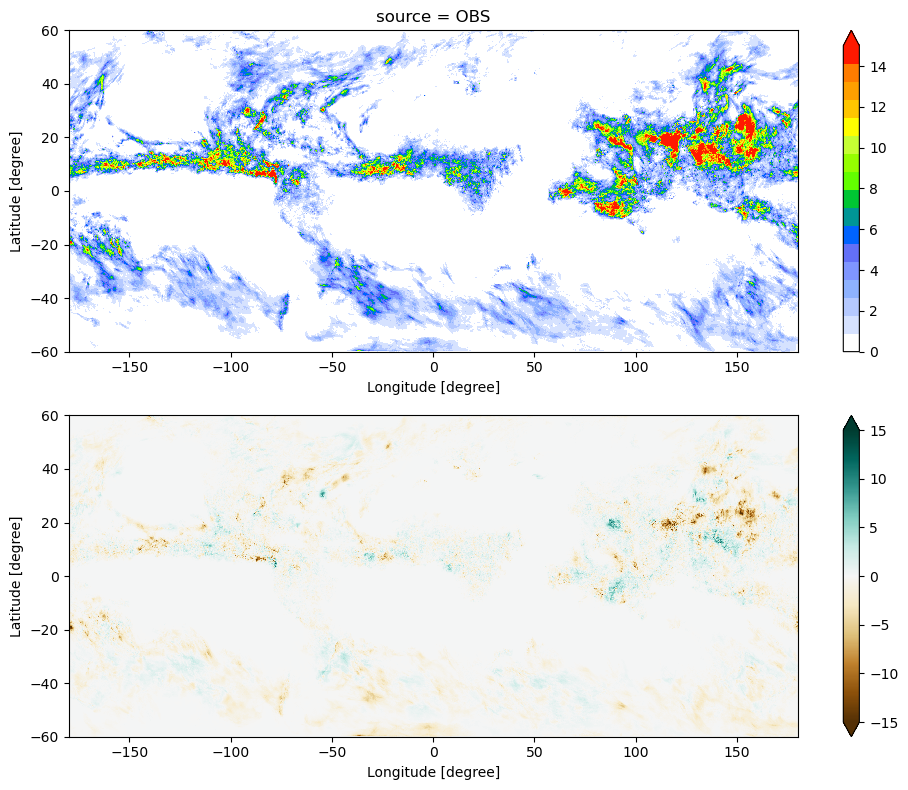

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
mcspcp.sel(source=run_name1).plot(vmin=0, vmax=15, cmap=cmap, ax=axes[0])
mcspcp_diff.plot(vmin=-15, vmax=15, cmap='BrBG', ax=axes[1])
fig.tight_layout()

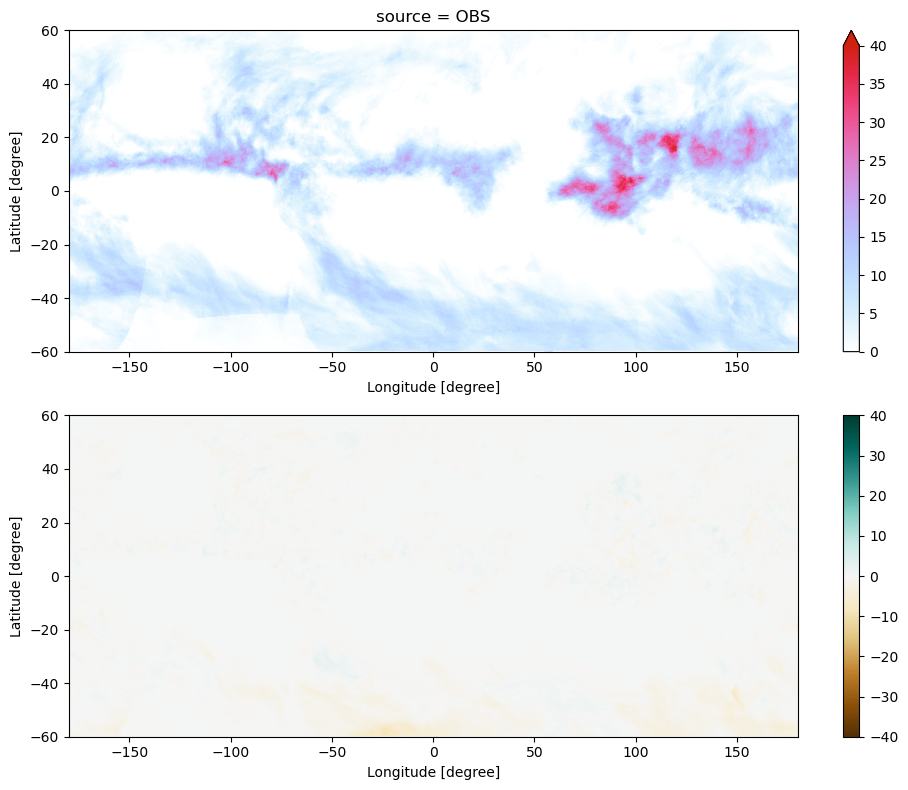

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
mcscloudfreq.sel(source=run_name1).plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
mcscloudfreq_diff.plot(vmin=-40, vmax=40, cmap='BrBG', ax=axes[1])
fig.tight_layout()

In [12]:
# mcspcp_obs.plot(vmin=0, vmax=15)

In [13]:
# totpcp_diff.plot(vmin=-15, vmax=15, cmap='BrBG')

In [14]:
# mcspcp_diff.plot(vmin=-10, vmax=10, cmap='BrBG')

In [15]:
# mcspcpfrac_diff.plot(cmap='BrBG')

In [16]:
# mcspcpfreq_diff.plot(cmap='BrBG')

In [17]:
# mcscloudfreq_diff.plot(cmap='BrBG')

## Specify regional boundaries for calculating mean values

In [18]:
if PHASE == 'Winter':
    box_mc = [95%360,150%360,-20,5]
    box_itcz = [151%360,-110%360,0,12]
    box_spcz = [151%360,-150%360,-30,-1]
    box_io = [50%360,94%360,-15,5]
    box_afc = [10%360,40%360,-20,5]
    box_amz = [-75%360,-40%360,-20,0]
    box_ao = [-40%360,-10%360,-8,8]
    box_amz180 = [-75,-40,-20,0]
    box_ao180 = [-40,-10,-8,8]
    boxes = {'MC':box_mc, 
             'ITCZ':box_itcz, 
             'SPCZ':box_spcz, 
             'IO':box_io, 
             'AO':box_ao,
             'AFC':box_afc, 
             'AMZ':box_amz, 
             }
    region_names = dict(zip(boxes.keys(), boxes.keys()))

    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['MC'][3]+3,
        boxes['ITCZ'][3]+3,
        boxes['SPCZ'][2]-8, 
        boxes['IO'][2]-8, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-8, 
        boxes['AMZ'][2]-8,         
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [19]:
if PHASE == 'Summer':
    box_mc = [95,150,-20,5]
    box_itcz = [-179,-70,5,18]
    box_io = [50,94,-15,5]
    box_wpac = [125,178,0,30]
    box_sam = [70,125,5,40]
    box_afc = [-15,40,-5,18]
    box_amz = [-75,-40,-20,0]
    box_ao = [-60,-15,5,18]
    box_cus = [-105, -80, 30, 50]
    box_ao180 = [-60,-15,5,18]
    box_cus180 = [-105, -80, 30, 50]
    boxes = {
        'WP':box_wpac,
        'ITCZ':box_itcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'SAM':box_sam,
        'CUS':box_cus,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['WP'][3]+3,
        boxes['ITCZ'][3]+3, 
        boxes['IO'][2]-8, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-8, 
        boxes['SAM'][3]+3,
        boxes['CUS'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [20]:
text_loc

{'WP': (151.5, 33),
 'ITCZ': (-124.5, 21),
 'IO': (72.0, -23),
 'AO': (-37.5, 21),
 'AFC': (12.5, -13),
 'SAM': (97.5, 43),
 'CUS': (-92.5, 53)}

## Function to calculate regional mean

In [21]:
# def calc_regional_mean(da, boxes):
#     """
#     Calculate regional mean for all sources
#     Args:
#         da: DataArray
#             Data Array containing dimensions (source, lat, lon)
#         boxes: dictionary
#             Dictionary containing region names and lat/lon bounds
        
#     Returns:
#         dict_out: dictionary
#             Dictionary containing mean difference for each box.
#     """
#     # Get number of sources
#     nsource = da.sizes['source']
#     # Get number of boxes
#     nbox = len(boxes)
#     # Get source names
#     source_names = list(da.source.data[:])
    
#     # Make arrays to store the differences
#     mean_reg = np.zeros((nsource,nbox), dtype=float)
#     dict_out = {}
    
#     # Loop over each region
#     for ii, name in enumerate(boxes):       
#         # Select (subset) the region
#         ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
#         # Average over the region
#         mean_reg[:,ii] = ida.mean(dim=('lat','lon'))
        
#     # Put values in dictionary
#     dict_out = dict(zip(source_names, mean_reg))
   
#     return dict_out

In [22]:
# dict_mcspcpAvg = calc_regional_mean(mcspcp, boxes)
# dict_mcspcpAvg

## Calculate regional mean difference

In [23]:
totpcp_reg_s1 = np.zeros(len(boxes), dtype=float)
totpcp_reg_s2 = np.zeros(len(boxes), dtype=float)
mcspcp_reg_s1 = np.zeros(len(boxes), dtype=float)
mcspcp_reg_s2 = np.zeros(len(boxes), dtype=float)
mcspcpfrac_reg_s1 = np.zeros(len(boxes), dtype=float)
mcspcpfrac_reg_s2 = np.zeros(len(boxes), dtype=float)
mcspcpfreq_reg_s1 = np.zeros(len(boxes), dtype=float)
mcspcpfreq_reg_s2 = np.zeros(len(boxes), dtype=float)
mcscloudfreq_reg_s1 = np.zeros(len(boxes), dtype=float)
mcscloudfreq_reg_s2 = np.zeros(len(boxes), dtype=float)
diff_totpcp_reg = np.zeros(len(boxes), dtype=float)
diff_mcspcp_reg = np.zeros(len(boxes), dtype=float)
diff_mcspcpfrac_reg = np.zeros(len(boxes), dtype=float)
diff_mcspcpfreq_reg = np.zeros(len(boxes), dtype=float)
diff_mcscloudfreq_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)

for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lon >= boxes[name][0]) & (lon <= boxes[name][1]))[0]
    yid = np.where((lat >= boxes[name][2]) & (lat <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    # Total rain
    tot_s2 = totpcp.sel(source=run_name2).data[min(yid):max(yid), min(xid):max(xid)]
    tot_s1 = totpcp.sel(source=run_name1).data[min(yid):max(yid), min(xid):max(xid)]
    totpcp_reg_s1[ii] = np.nanmean(tot_s1)
    totpcp_reg_s2[ii] = np.nanmean(tot_s2)
    diff_totpcp_reg[ii] = 100 * (np.nansum(tot_s2) - np.nansum(tot_s1)) / np.nansum(tot_s1)
    # MCS rain
    mcs_s2 = mcspcp.sel(source=run_name2).data[min(yid):max(yid), min(xid):max(xid)]
    mcs_s1 = mcspcp.sel(source=run_name1).data[min(yid):max(yid), min(xid):max(xid)]
    mcspcp_reg_s1[ii] = np.nanmean(mcs_s1)
    mcspcp_reg_s2[ii] = np.nanmean(mcs_s2)
    diff_mcspcp_reg[ii] = 100 * (np.nansum(mcs_s2) - np.nansum(mcs_s1)) / np.nansum(mcs_s1)
    # MCS rain frequency
    mcspcpfreq_s2 = mcspcpfreq.sel(source=run_name2).data[min(yid):max(yid), min(xid):max(xid)]
    mcspcpfreq_s1 = mcspcpfreq.sel(source=run_name1).data[min(yid):max(yid), min(xid):max(xid)]
    mcspcpfreq_reg_s1[ii] = np.nanmean(mcspcpfreq_s1)
    mcspcpfreq_reg_s2[ii] = np.nanmean(mcspcpfreq_s2)
    diff_mcspcpfreq_reg[ii] = 100 * (np.nansum(mcspcpfreq_s2) - np.nansum(mcspcpfreq_s1)) / np.nansum(mcspcpfreq_s1)
    # MCS cloud frequency
    mcscloudfreq_s2 = mcscloudfreq.sel(source=run_name2).data[min(yid):max(yid), min(xid):max(xid)]
    mcscloudfreq_s1 = mcscloudfreq.sel(source=run_name1).data[min(yid):max(yid), min(xid):max(xid)]
    mcscloudfreq_reg_s1[ii] = np.nanmean(mcscloudfreq_s1)
    mcscloudfreq_reg_s2[ii] = np.nanmean(mcscloudfreq_s2)
    diff_mcscloudfreq_reg[ii] = 100 * (np.nansum(mcscloudfreq_s2) - np.nansum(mcscloudfreq_s1)) / np.nansum(mcscloudfreq_s1)
    
    # MCS rain fraction
    mcspcpfrac_reg_s1[ii] = 100 * np.nansum(mcs_s1) / np.nansum(tot_s1)
    mcspcpfrac_reg_s2[ii] = 100 * np.nansum(mcs_s2) / np.nansum(tot_s2)
    # Difference in regional mean MCS rain fraction
    diff_mcspcpfrac_reg[ii] = mcspcpfrac_reg_s2[ii] - mcspcpfrac_reg_s1[ii]

# Put mean values in dictionaries
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val_totpcp_diff = dict(zip(boxes.keys(), diff_totpcp_reg))
text_val_mcspcp_diff = dict(zip(boxes.keys(), diff_mcspcp_reg))
text_val_mcspcpfrac_diff = dict(zip(boxes.keys(), diff_mcspcpfrac_reg))
text_val_mcspcpfreq_diff = dict(zip(boxes.keys(), diff_mcspcpfreq_reg))
text_val_mcscloudfreq_diff = dict(zip(boxes.keys(), diff_mcscloudfreq_reg))

text_val_totpcp_s1 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in totpcp_reg_s1]))
text_val_totpcp_s2 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in totpcp_reg_s2]))
text_val_mcspcp_s1 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in mcspcp_reg_s1]))
text_val_mcspcp_s2 = dict(zip(boxes.keys(), [f"{value:.1f} mm/d" for value in mcspcp_reg_s2]))
text_val_mcspcpfrac_s1 = dict(zip(boxes.keys(), [f"{value:.0f}%" for value in mcspcpfrac_reg_s1]))
text_val_mcspcpfrac_s2 = dict(zip(boxes.keys(), [f"{value:.0f}%" for value in mcspcpfrac_reg_s2]))
text_val_mcspcpfreq_s1 = dict(zip(boxes.keys(), [f"{value:.1f}%" for value in mcspcpfreq_reg_s1]))
text_val_mcspcpfreq_s2 = dict(zip(boxes.keys(), [f"{value:.1f}%" for value in mcspcpfreq_reg_s2]))
text_val_mcscloudfreq_s1 = dict(zip(boxes.keys(), [f"{value:.1f}%" for value in mcscloudfreq_reg_s1]))
text_val_mcscloudfreq_s2 = dict(zip(boxes.keys(), [f"{value:.1f}%" for value in mcscloudfreq_reg_s2]))
# Shift SPCZ text location for Winter
if PHASE == 'Winter':
    text_loc['SPCZ'] = text_loc['SPCZ'][0] + 20, text_loc['SPCZ'][1]
# print(text_loc)
print(text_val_totpcp_diff)
print(text_val_mcspcp_diff)
print(text_val_mcspcpfrac_diff)
print(text_val_mcspcpfreq_diff)
print(text_val_mcscloudfreq_diff)

{'WP': -2.8791661185683677, 'ITCZ': -1.444853963782574, 'IO': 2.2871719793786776, 'AO': -3.4142913014534817, 'AFC': 3.347893136216002, 'SAM': 0.373925090523226, 'CUS': -1.1686846153276844}
{'WP': -8.72379826022004, 'ITCZ': -8.657076980990025, 'IO': 0.9480674194013724, 'AO': -7.510223756812978, 'AFC': 1.169768448962909, 'SAM': -4.292450748038771, 'CUS': -1.9826233081325484}
{'WP': -4.503189798510604, 'ITCZ': -4.824676502115246, 'IO': -0.9135070900795483, 'AO': -2.581534293291753, 'AFC': -1.3259841397187984, 'SAM': -2.953833416691083, 'CUS': -0.4840547828440336}
{'WP': 2.4062285701537536, 'ITCZ': 4.143450374797793, 'IO': 5.293264994791425, 'AO': 0.8853311210842211, 'AFC': 3.0217968391090397, 'SAM': 4.221381537055488, 'CUS': 3.5097257318000623}
{'WP': -0.1981908026915374, 'ITCZ': -0.432487540891509, 'IO': 1.0650012892956409, 'AO': -0.4722102140000188, 'AFC': 0.9176989560375278, 'SAM': -0.5381950784098352, 'CUS': -0.8792507243219527}


## Function to plot two maps (1 colorbar)

In [24]:
def plot_2maps_1cb(dataarray, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                   oob_colors=None, contourf=False, 
                   boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    # map_extent = [0., 359.5, -60.1, 60.1]
    map_extent = [-180., 179.9, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    # text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
        # Lat/lon grid
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)           
        if (pp == 1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
        norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
        # Set out-of-bound colors
        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels), max(levels))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)

                if boxtexttype is None:
                    text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.00f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                else:
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    # Plot 1 colorbar by manually adding a new axes
    cax1 = fig.add_axes([0.90, 0.1, 0.02, 0.8])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabel, ticks=cbticks, orientation='vertical', extend='both')
    cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

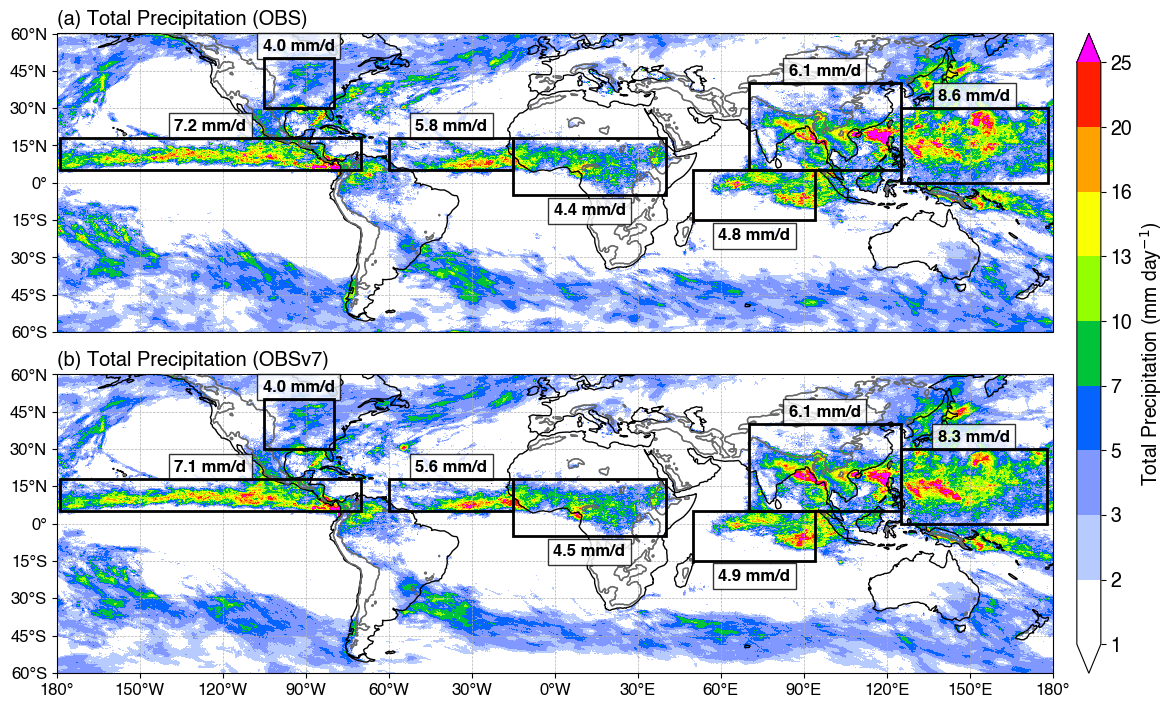

In [25]:
titles = [f'(a) Total Precipitation ({run_name1})', f'(b) Total Precipitation ({run_name2})']
dataarr = [totpcp.sel(source=run_name1), totpcp.sel(source=run_name2)]
levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = levels
cblabel = 'Total Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}globalmap_total_rain_{run_name1}_{run_name2}.png'
oob_colors = {'under':'white', 'over':'magenta'}
text_val = [text_val_totpcp_s1, text_val_totpcp_s2]
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

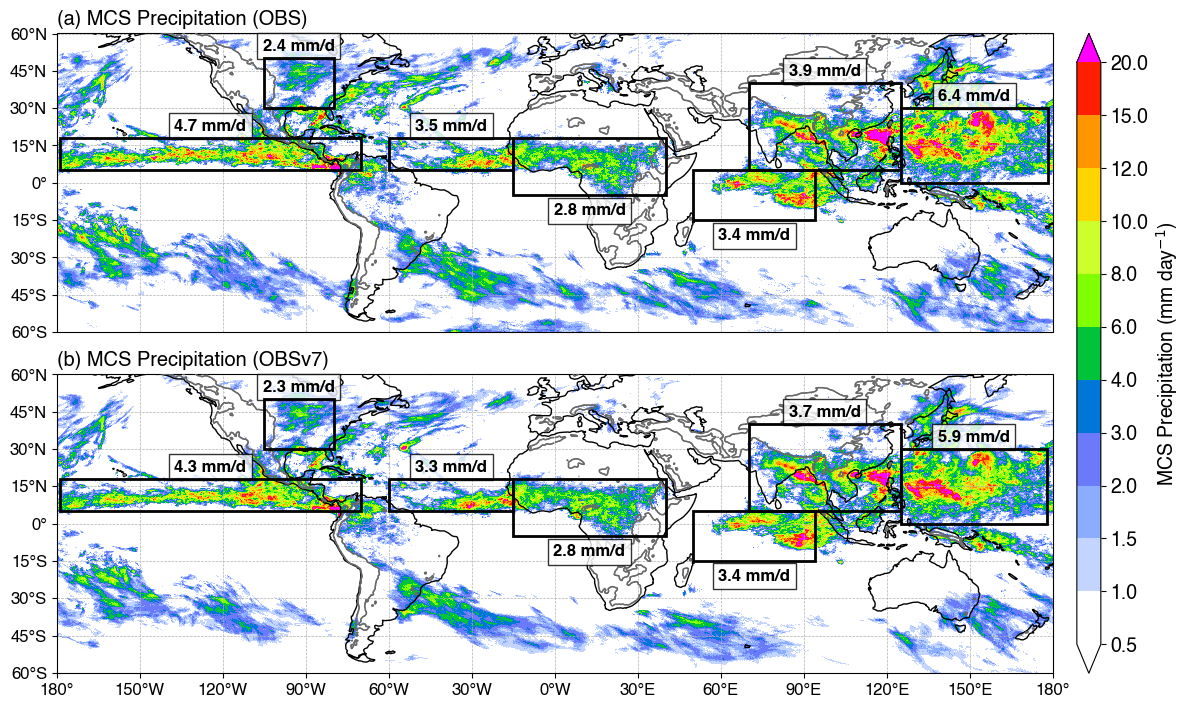

In [26]:
titles = [f'(a) MCS Precipitation ({run_name1})', f'(b) MCS Precipitation ({run_name2})']
dataarr = [mcspcp.sel(source=run_name1), mcspcp.sel(source=run_name2)]
levels = [0.5,1,1.5,2,3,4,6,8,10,12,15,20]
cbticks = levels
cblabel = 'MCS Precipitation (mm day$^{-1}$)'
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}globalmap_mcs_rain_{run_name1}_{run_name2}.png'
oob_colors = {'under':'white', 'over':'magenta'}
text_val = [text_val_mcspcp_s1, text_val_mcspcp_s2]
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

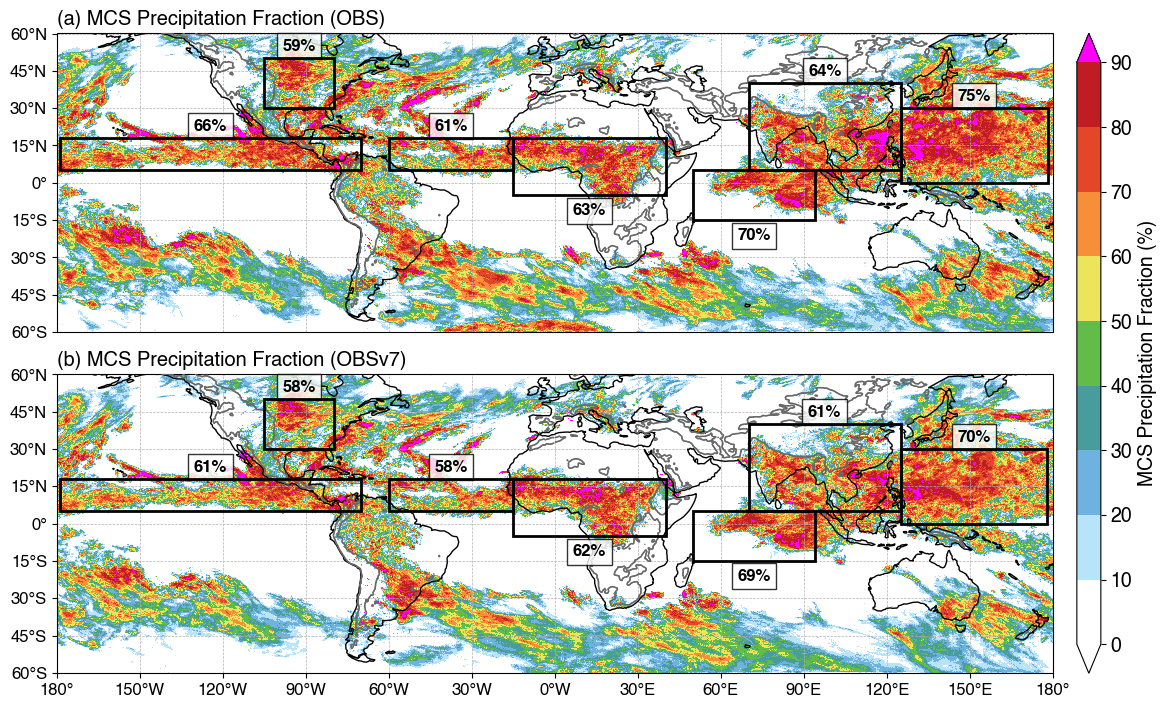

In [27]:
titles = [f'(a) MCS Precipitation Fraction ({run_name1})',f'(b) MCS Precipitation Fraction ({run_name2})']
dataarr = [mcspcpfrac.sel(source=run_name1), mcspcpfrac.sel(source=run_name2)]
levels = np.arange(0, 90.01, 10)
cbticks = levels
cblabel = 'MCS Precipitation Fraction (%)'
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
figname = f'{figdir}globalmap_mcs_rainfrac_{run_name1}_{run_name2}.png'
oob_colors = {'under':'white', 'over':'magenta'}
text_colors = {'pos':'k', 'neg':'k'}
text_val = [text_val_mcspcpfrac_s1, text_val_mcspcpfrac_s2]
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

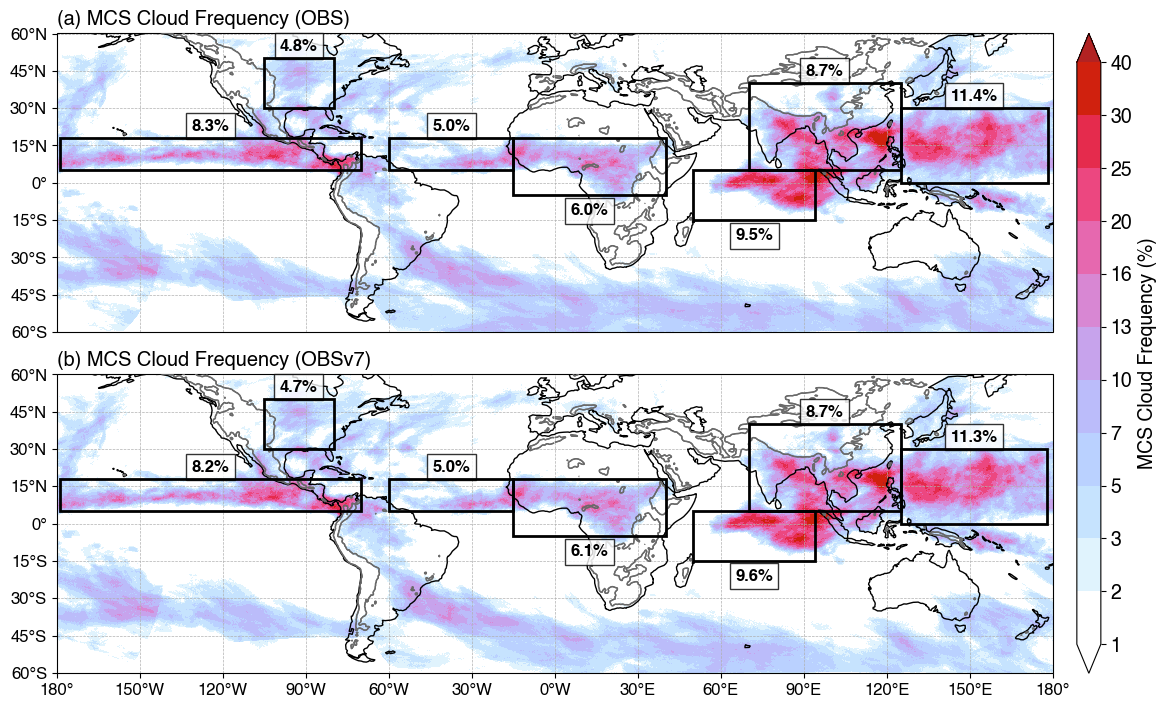

In [28]:
titles = [f'(a) MCS Cloud Frequency ({run_name1})',f'(b) MCS Cloud Frequency ({run_name2})']
dataarr = [mcscloudfreq.sel(source=run_name1), mcscloudfreq.sel(source=run_name2)]
levels = [1,2,3,5,7,10,13,16,20,25,30,40]
cbticks = levels
cblabel = 'MCS Cloud Frequency (%)'
cmap = cc.cm.CET_L19
# cmap = truncate_colormap(cmap, 0.0, 0.9)
figname = f'{figdir}globalmap_mcs_cloudfreq_{run_name1}_{run_name2}.png'
oob_colors = {'under':'white', 'over':'firebrick'}
text_colors = {'pos':'k', 'neg':'k'}
text_val = [text_val_mcscloudfreq_s1, text_val_mcscloudfreq_s2]
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

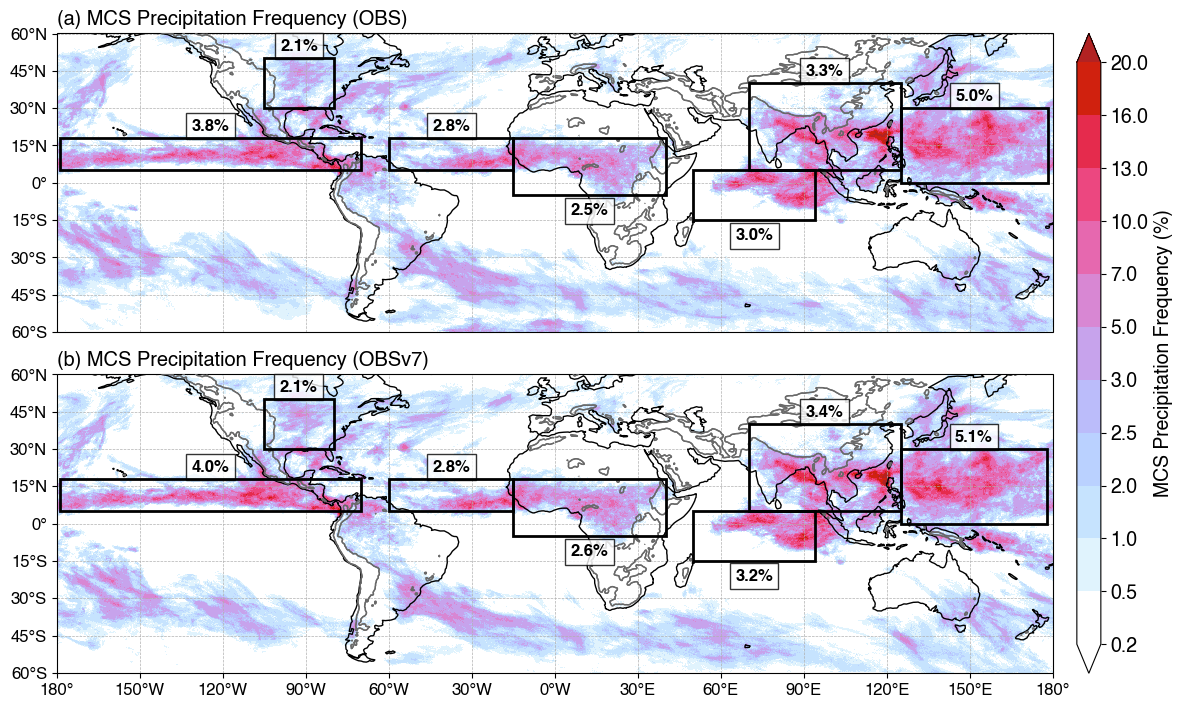

In [29]:
titles = [f'(a) MCS Precipitation Frequency ({run_name1})',f'(b) MCS Precipitation Frequency ({run_name2})']
dataarr = [mcspcpfreq.sel(source=run_name1), mcspcpfreq.sel(source=run_name2)]
levels = [0.2,0.5,1.0,2.0,2.5,3,5,7,10,13,16,20]
cbticks = levels
cblabel = 'MCS Precipitation Frequency (%)'
cmap = cc.cm.CET_L19
# cmap = truncate_colormap(cmap, 0.0, 0.9)
figname = f'{figdir}globalmap_mcs_rainfreq_{run_name1}_{run_name2}.png'
oob_colors = {'under':'white', 'over':'firebrick'}
text_colors = {'pos':'k', 'neg':'k'}
text_val = [text_val_mcspcpfreq_s1, text_val_mcspcpfreq_s2]
fig = plot_2maps_1cb(dataarr, lon, lat, titles, levels, cmap, cblabel, cbticks, figname, 
                     contourf=False, oob_colors=oob_colors,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors, boxtexttype='string')

## Function to plot two maps (2 colorbars)

In [30]:
def plot_2maps_2cb(dataarray, lon, lat, titles, levels, cmap, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,8], dpi=100)
    gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,0.02])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp,0], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
#         ax.add_feature(land, facecolor='lightgray')
#         ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])

        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
            
        if (pp == 1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
        norm = colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels[pp], norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)

        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))

        # Plot boxes
        if boxes is not None:
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)

                if boxtexttype is None:
                    text_color = text_colors['pos'] if (boxtext[pp][ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]:.00f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                else:
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[pp][ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                
        # Colorbars
        cax1 = plt.subplot(gs[pp,1])
        cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[pp], ticks=cbticks[pp], orientation='vertical', extend='both')
        # cb1.set_label(cblabel, fontsize=14)
        cb1.ax.tick_params(labelsize=14)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

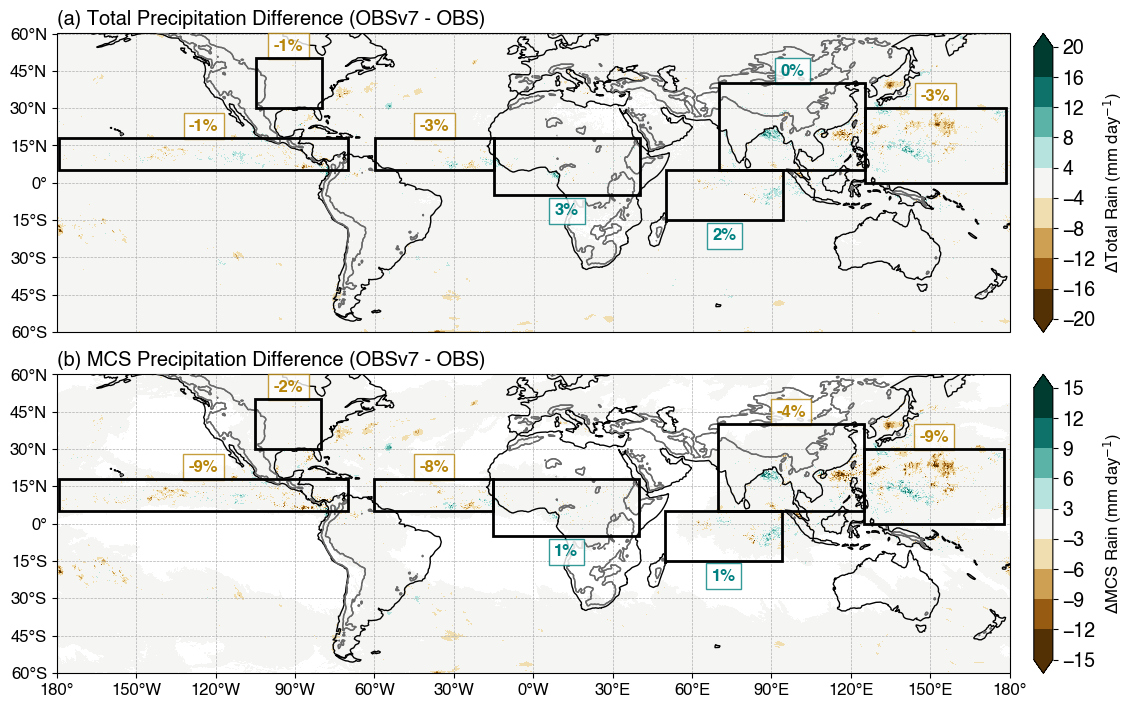

In [31]:
titles = [f'(a) Total Precipitation Difference ({run_name2} - {run_name1})',f'(b) MCS Precipitation Difference ({run_name2} - {run_name1})']
dataarr = [totpcp_diff, mcspcp_diff]
lev1 = [-20,-16,-12,-8,-4,4,8,12,16,20]
lev2 = [-15,-12,-9,-6,-3,3,6,9,12,15]
cbticks1 = lev1
cbticks2 = lev2
levels = [lev1, lev2]
cbticks = [cbticks1, cbticks2]
cblabels = ['$\Delta$Total Rain (mm day$^{-1}$)', '$\Delta$MCS Rain (mm day$^{-1}$)']
cmap = 'BrBG'
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
text_val = [text_val_totpcp_diff, text_val_mcspcp_diff]
figname = f'{figdir}globalmap_total_mcs_rain_diff_{run_name1}_{run_name2}.png'
fig = plot_2maps_2cb(dataarr, lon, lat, titles, levels, cmap, cblabels, cbticks, figname, contourf=False,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors)

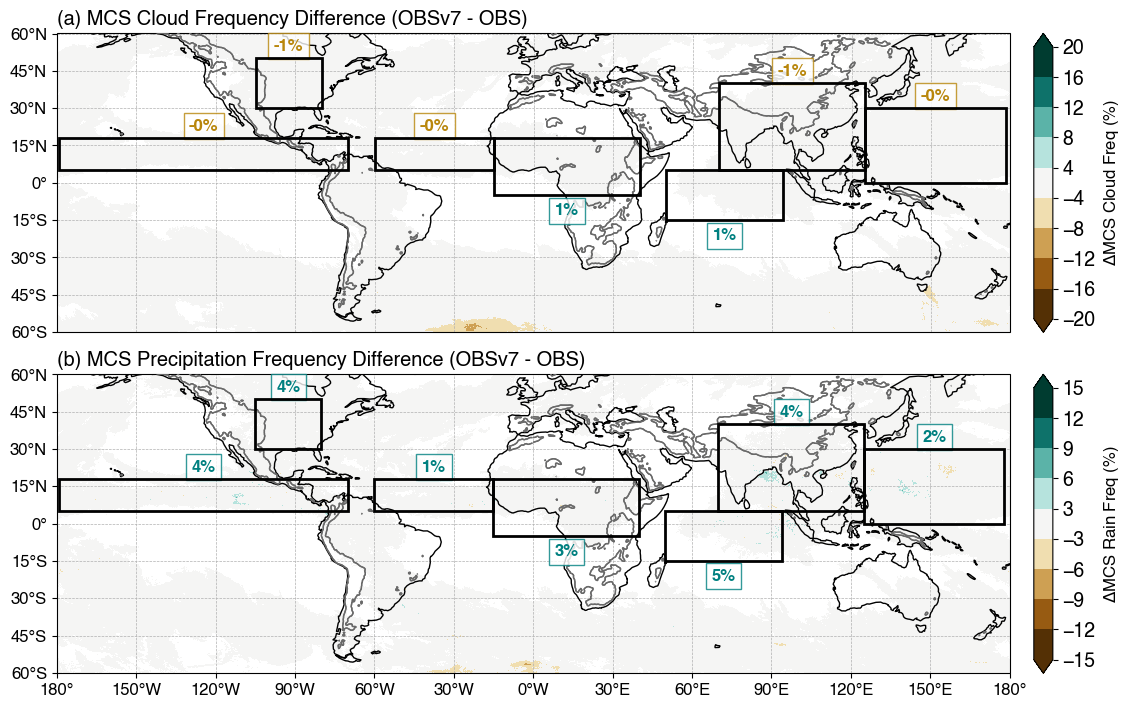

In [32]:
titles = [f'(a) MCS Cloud Frequency Difference ({run_name2} - {run_name1})',f'(b) MCS Precipitation Frequency Difference ({run_name2} - {run_name1})']
dataarr = [mcscloudfreq_diff, mcspcpfreq_diff]
lev1 = [-20,-16,-12,-8,-4,4,8,12,16,20]
lev2 = [-15,-12,-9,-6,-3,3,6,9,12,15]
# lev2 = [-30,-25,-20,-15,-10,-5,5,10,15,20,25,30]
cbticks1 = lev1
cbticks2 = lev2
levels = [lev1, lev2]
cbticks = [cbticks1, cbticks2]
cblabels = ['$\Delta$MCS Cloud Freq (%)', '$\Delta$MCS Rain Freq (%)']
cmap = 'BrBG'
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}
text_val = [text_val_mcscloudfreq_diff, text_val_mcspcpfreq_diff]
figname = f'{figdir}globalmap_mcs_cloudrainfreq_diff_{run_name1}_{run_name2}.png'
fig = plot_2maps_2cb(dataarr, lon, lat, titles, levels, cmap, cblabels, cbticks, figname, contourf=False,
                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, text_colors=text_colors)

In [33]:
figdir

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/PyFLEXTRKR/'